In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
import json
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import warnings
warnings.filterwarnings("ignore")

import glob

import sys
sys.path.append('../../')

import json

In [2]:
with open("../../config/config_notebooks_Ovarian.json", "r") as config_file:
    config = json.load(config_file)

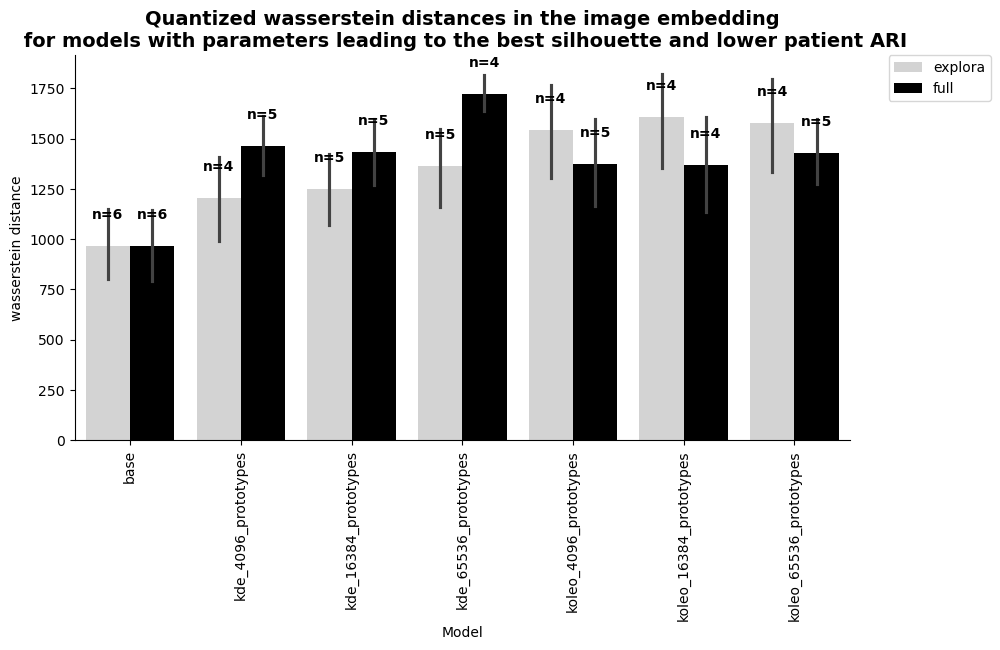

In [3]:
df_summary = pd.DataFrame(columns=["n_clusters", 
                                   "wasserstein_distances", 
                                   "mean_wasserstein_distance", 
                                   "std_wasserstein_distance", 
                                   "median_wasserstein_distance", 
                                   "min_wasserstein_distance", 
                                   "max_wasserstein_distance",
                                   "model_type",
                                   "params"])
summary_list = []
all_names = []
wassersteins = []
optimal_clusters = pd.DataFrame()
for model_type, names, path in zip([config['retrained_model_list1_type'],
                             config['retrained_model_list2_type']],
                             [config['retrained_model_list1'],
                              config['retrained_model_list2']],
                              [config['retrained_benchmark_folder1'],
                               config['retrained_benchmark_folder2']]):
    
    path_to_invasive_cancer_clustering_results = os.path.join(path, "invasive_cancer_clustering", config['invasive_cancer_clustering_algo'])
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "optimal_clusters.csv"), index_col=0)
    dfs = []

    
    


    for name in names:
        # print(os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv"))
        # filenames = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_*_clusters.csv"))
        # if len(filenames) == 0:
        #     print(f"No file found for {name}, {model_type}")
        # filename = filenames[0]
        filename = os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv")
        df = pd.read_csv(filename, index_col=0)

        n = opti_clusters.loc[name, 'n_clusters']
        optimal_clusters.loc[name, 'n_clusters'] = n

        n_clusters = df.shape[0]      
        # Get the lower triangular part of the matrix without the diagonal values
        lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
        wasserstein_distances = lower_matrix.stack().values
        wassersteins.append(wasserstein_distances)


        mean_wasserstein_distance = np.mean(wasserstein_distances)
        std_wasserstein_distance = np.std(wasserstein_distances)
        median_wasserstein_distance = np.median(wasserstein_distances)

        min_wasserstein_distance = np.min(wasserstein_distances)
        max_wasserstein_distance = np.max(wasserstein_distances)

        if name == "uni":
            params = "base"
        else:
            params = "_".join(name.split("_")[2:])

        summary_list.append({"n_clusters": n_clusters, 
                            "wasserstein_distances": wasserstein_distances, 
                            "mean_wasserstein_distance": mean_wasserstein_distance, 
                            "std_wasserstein_distance": std_wasserstein_distance, 
                            "median_wasserstein_distance": median_wasserstein_distance, 
                            "min_wasserstein_distance": min_wasserstein_distance, 
                            "max_wasserstein_distance": max_wasserstein_distance,
                            "model_type": model_type, 
                            "params": params})
        
        if name == "uni":
            name = f"uni_{model_type}"

        dfs.append(df)
        all_names.append(name)

df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
df_summary.index = all_names




df_sink = pd.DataFrame(wassersteins, index=all_names).T
df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")

plt.figure(figsize=(10, 5))
sns.barplot(data=df_sink_melted, x="param", y="wasserstein_distance", hue="model_type", palette={"full": "black", "explora": "lightgrey"})
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"Quantized wasserstein distances in the image embedding\n for models with parameters leading to the best silhouette and lower patient ARI", weight="bold", fontsize=14)


for i, model_type in enumerate(df_summary['model_type'].unique()):
    for j in range(len(df_summary[df_summary['model_type'] == model_type])):
        distances = df_summary[df_summary['model_type'] == model_type]["mean_wasserstein_distance"].values
        deviations = df_summary[df_summary['model_type'] == model_type]["std_wasserstein_distance"].values
        nb_clusters = df_summary[df_summary['model_type'] == model_type]["n_clusters"].values
        if i == 0:
            plt.text(j - 0.2, distances[j]+120, f"n={nb_clusters[j]}", ha='center', va='bottom', weight='bold')
        else:
            plt.text(j + 0.2, distances[j]+120, f"n={nb_clusters[j]}", ha='center', va='bottom', weight='bold')

sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(config['figures_folder'], "Figure4/invasive_cancer_clustering_quantized_wasserstein_distances_image_embedding_for_clusters_defined_with_best_silhouette_and_lower_ARI_patient.pdf"), bbox_inches="tight")
#plt.tight_layout()

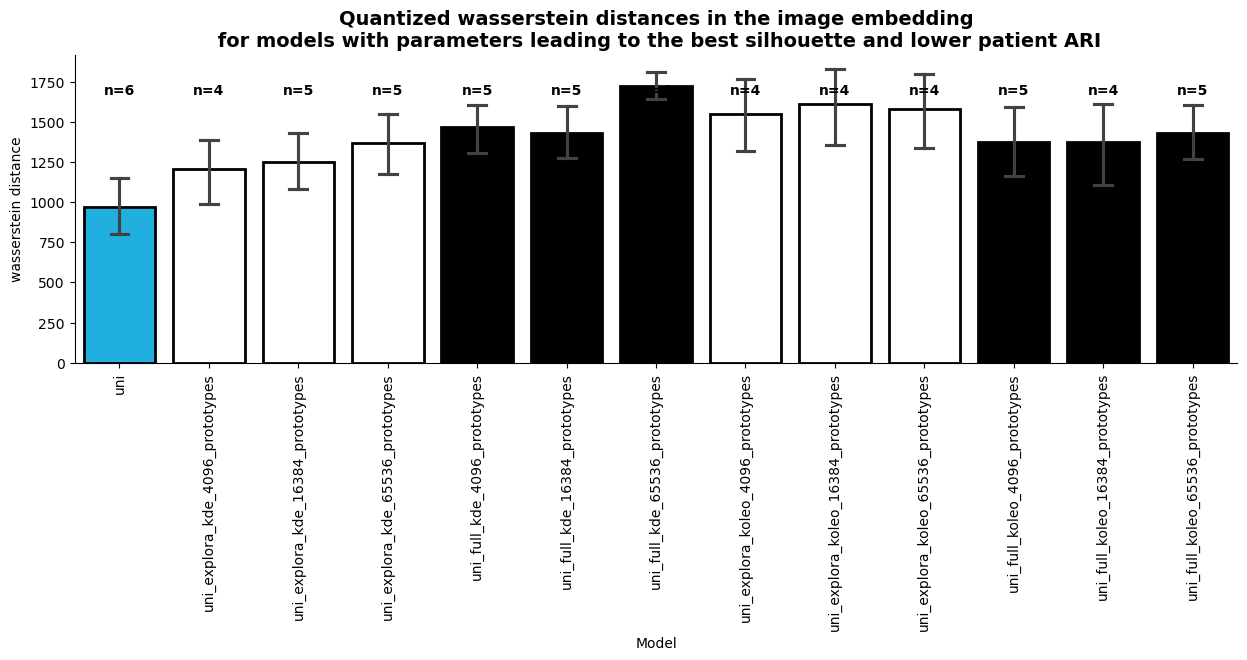

In [4]:
dfs = []
n_clusters = []

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

sorted_models = sort_retrained_models(config['retrained_model_list1'] + config['retrained_model_list2'])
for model_type in sorted_models:
    if model_type == "uni":
        df = df_sink_melted[df_sink_melted['model'] == "uni_explora"]
        df['model'] = "uni"
        n_clusters.append(df_summary.loc['uni_explora', 'n_clusters'])
    else:
        df = df_sink_melted[df_sink_melted['model'] == model_type]
        n_clusters.append(df_summary.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)


palette = []
for model in sorted_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', 
            y="wasserstein_distance", 
            palette=palette, 
            linewidth=2,
            edgecolor="black",
            capsize=0.2,
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"Quantized wasserstein distances in the image embedding\n for models with parameters leading to the best silhouette and lower patient ARI", weight="bold", fontsize=14)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=1650, s=f"n={n}", ha='center', va='bottom', weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure4/invasive_cancer_clustering_quantized_wasserstein_distances_image_embedding_for_clusters_defined_with_best_silhouette_and_lower_ARI_patient.pdf"), bbox_inches="tight")
